<a href="https://colab.research.google.com/github/bevislau/Data_Project/blob/main/Predict_Visitor_Purchases_with_a_Classification_Model_in_BigQuery_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='gifted-country-461816-i9')

import matplotlib.pyplot as plt
import seaborn as sns


# Data Exploration & Preparation

## crm_account_cleaned

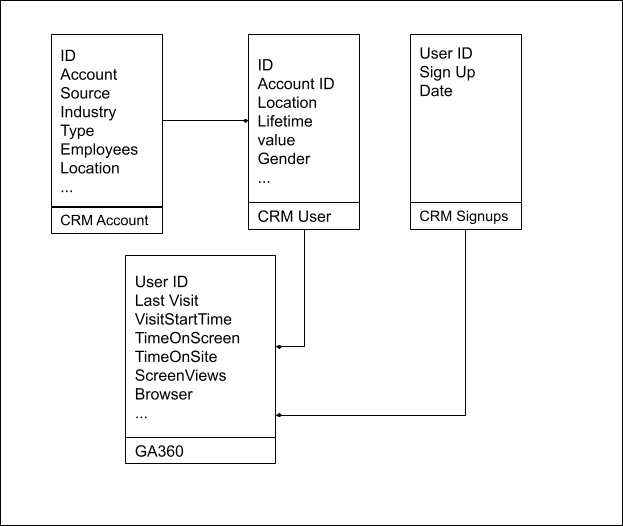

In [ ]:
query = """
SELECT
  column_name,
  data_type,
  is_nullable
FROM `gifted-country-461816-i9.b2b_database.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'crm_account_cleaned'
ORDER BY ordinal_position;
"""

df = client.query(query).to_dataframe()
display(df)




,column_name,data_type,is_nullable
0,account_number,INT64,YES
1,account_source,INT64,YES
2,annual_revenue,FLOAT64,YES
3,state_code,STRING,YES
4,country_code,STRING,YES
5,channel_program_name,INT64,YES
6,industry,STRING,YES
7,name,STRING,YES
8,number_of_employees,INT64,YES
9,ownership,INT64,YES


In [ ]:
query = """
SELECT
  column_name,
  data_type,
  is_nullable
FROM `gifted-country-461816-i9.b2b_database.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'crm_user'
ORDER BY ordinal_position;
"""

df = client.query(query).to_dataframe()
display(df)




,column_name,data_type,is_nullable
0,User_ID,INT64,YES
1,Account_ID,INT64,YES
2,Name,STRING,YES
3,Loyalty_Program,INT64,YES
4,State_Code,STRING,YES
5,Country_Code,STRING,YES
6,LifeTime_Value,FLOAT64,YES
7,Age,INT64,YES


In [3]:
# Query your table (limit rows for quicker exploration)
query = """
SELECT * FROM `gifted-country-461816-i9.b2b_database.crm_user`
"""

# Load to DataFrame
df = client.query(query).to_dataframe()

# Show summary statistics for numeric fields
print(df.describe())

            User_ID  Account_ID  Loyalty_Program  LifeTime_Value       Age
count        1000.0      1000.0           1000.0     1000.000000     991.0
mean      24730.097    1252.221            1.512   156976.859562  41.45005
std    11206.597146  305.409871         0.595156   166251.896679  6.006669
min           597.0       103.0              0.0        0.000000      23.0
25%        15428.75     1055.75              1.0     3023.513514      37.0
50%         24523.5      1242.0              2.0    84246.441296      41.0
75%         34104.0      1446.0              2.0   339325.000000      45.0
max         47882.0      2303.0              3.0   645675.069767      64.0


Loyalty Program Tier Distriubtion

From the result, there are not significant difference between the tiers in Loyalty program rank

*   Potentially, there are other factors grouping the tier

In [ ]:
query = """
SELECT Loyalty_Program,ROUND(AVG(lifeTime_Value),1) As Avg_ltv, Count(*) AS no_of_users
FROM `gifted-country-461816-i9.b2b_database.crm_user`
GROUP BY loyalty_program
"""

df = client.query(query).to_dataframe()
display(df)

,Loyalty_Program,Avg_ltv,no_of_users
0,0,156183.6,25
1,1,157148.8,465
2,2,158920.5,483
3,3,119981.1,27


## Customer lifetime value

the data is higly skewed right, with quiet a number of customers with 0 LTV

       lifeTime_Value
count     1000.000000
mean    156976.859562
std     166251.896679
min          0.000000
25%       3023.513514
50%      84246.441296
75%     339325.000000
max     645675.069767


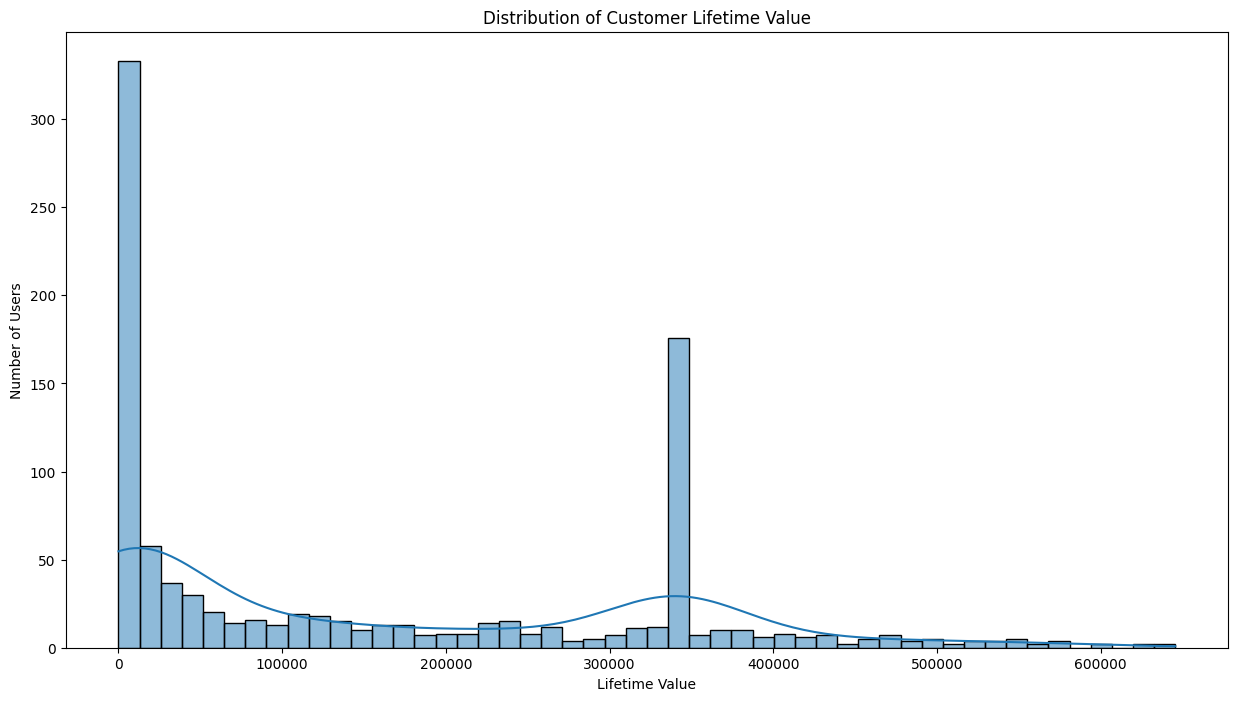

In [ ]:

query = """
SELECT lifeTime_Value
FROM `gifted-country-461816-i9.b2b_database.crm_user`
"""

# Load to DataFrame
df = client.query(query).to_dataframe()

# Show summary statistics for numeric fields
print(df.describe())

plt.figure(figsize=(15, 8))
sns.histplot(df['lifeTime_Value'], bins=50, kde=True)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('Lifetime Value')
plt.ylabel('Number of Users')
plt.show()

## ga360 table

In [ ]:
query = """
SELECT
  column_name,
  data_type,
  is_nullable
FROM `gifted-country-461816-i9.b2b_database.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'ga360'
ORDER BY ordinal_position;
"""

df = client.query(query).to_dataframe()
display(df)

,column_name,data_type,is_nullable
0,Visit_ID,INT64,YES
1,User_ID,INT64,YES
2,Activity_Date,DATE,YES
3,visitStartTime,INT64,YES
4,timeOnScreen,INT64,YES
5,timeOnSite,INT64,YES
6,UniqueScreenViews,INT64,YES
7,Medium,INT64,YES
8,screenResolution,INT64,YES


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Query your table (limit rows for quicker exploration)
query = """
SELECT * FROM `gifted-country-461816-i9.b2b_database.ga360`
"""

# Load to DataFrame
df = client.query(query).to_dataframe()

# Show summary statistics for numeric fields
print(df.describe())

            Visit_ID      User_ID  visitStartTime  timeOnScreen  timeOnSite  \
count         1000.0       1000.0          1000.0        1000.0      1000.0   
mean      487211.659     24751.18      487211.659         501.4      99.663   
std    283964.085699  6296.193838   283964.085699    129.321615   24.282815   
min           1365.0       4990.0          1365.0         124.0        10.0   
25%        250141.25     20383.25       250141.25         412.0        84.0   
50%         487200.0      24858.0        487200.0         501.0       100.0   
75%        727667.25     29037.75       727667.25         586.0       116.0   
max         999947.0      44161.0        999947.0         932.0       180.0   

       UniqueScreenViews    Medium  screenResolution  
count             1000.0    1000.0            1000.0  
mean                2.52     1.504             3.475  
std             0.824791  0.595263          3.513078  
min                  0.0       0.0               0.0  
25%          

From this result, timeOnScreen, visitStartTime, timeOnSite can be analysed

While Medium and ScreenResolution seems have other indication

In [ ]:
query = """
WITH first_activity AS (
  SELECT
    User_ID,
    MIN(Activity_Date) AS First_Activity_Date
  FROM `gifted-country-461816-i9.b2b_database.ga360`
  GROUP BY User_ID
)

SELECT
  fa.User_ID,
  fa.First_Activity_Date,
  SUM(g.timeOnScreen) AS total_timeOnScreen,
  SUM(g.timeOnSite) AS total_timeOnSite
FROM first_activity fa
JOIN `gifted-country-461816-i9.b2b_database.ga360` g
  ON fa.User_ID = g.User_ID
  AND fa.First_Activity_Date = g.Activity_Date
GROUP BY fa.User_ID, fa.First_Activity_Date
ORDER BY total_timeOnScreen DESC
"""

df = client.query(query).to_dataframe()
print(df)

     User_ID First_Activity_Date  total_timeOnScreen  total_timeOnSite
0      32520          1989-06-03                 932                79
1      21637          1984-02-09                 928               112
2      25585          1996-02-20                 903               157
3      25327          1957-09-12                 897                66
4      27539          1976-11-08                 865                82
..       ...                 ...                 ...               ...
945    20830          1983-05-11                 187                88
946    29368          2019-09-13                 182               145
947    13001          1928-10-28                 144               114
948    41663          1950-01-26                 130               180
949    30192          2003-04-24                 124               115

[950 rows x 4 columns]


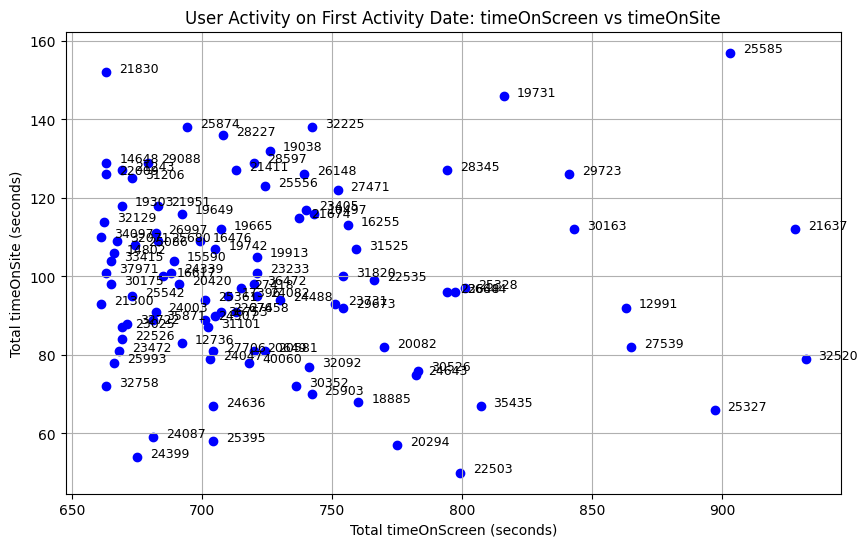

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['total_timeOnScreen'], df['total_timeOnSite'], color='blue')

# Add labels for each point (User_ID)
for i, user_id in enumerate(df['User_ID']):
    plt.text(df['total_timeOnScreen'][i] + 5, df['total_timeOnSite'][i], str(user_id), fontsize=9)

plt.xlabel('Total timeOnScreen (seconds)')
plt.ylabel('Total timeOnSite (seconds)')
plt.title('User Activity on First Activity Date: timeOnScreen vs timeOnSite')
plt.grid(True)
plt.show()

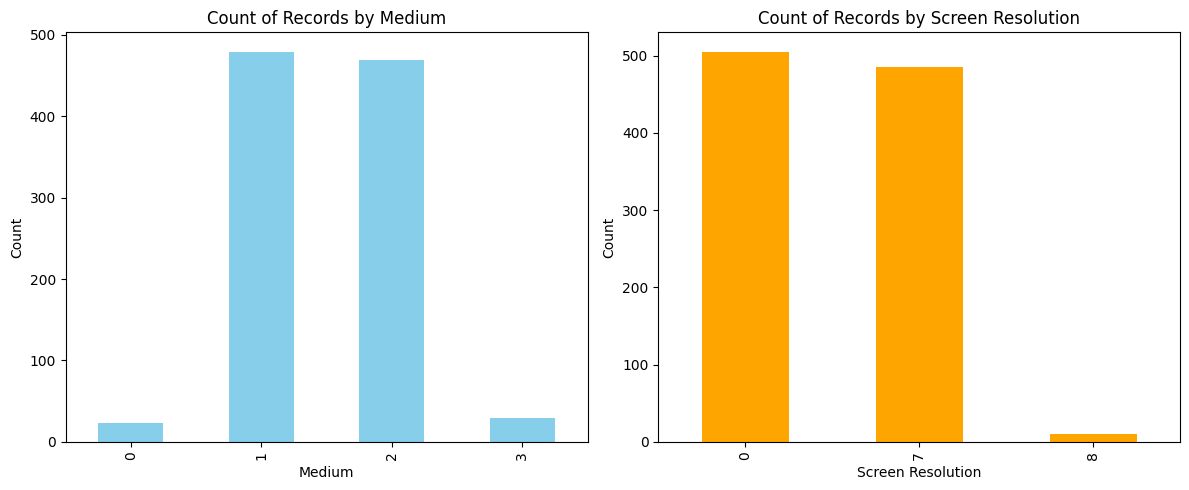

In [ ]:
# Plot for Medium
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
medium_counts = df['Medium'].value_counts().sort_index()
medium_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Records by Medium')
plt.xlabel('Medium')
plt.ylabel('Count')

# Plot for screenResolution
plt.subplot(1, 2, 2)
resolution_counts = df['screenResolution'].value_counts().sort_index()
resolution_counts.plot(kind='bar', color='orange')
plt.title('Count of Records by Screen Resolution')
plt.xlabel('Screen Resolution')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In this dataset GA360 data, we will extract timeOnScreen, timeOnScreen, Screen

In [9]:
query = """
SELECT *
FROM `gifted-country-461816-i9.b2b_database.users_signup_dates` ORDER BY user_id ASC
"""

df = client.query(query).to_dataframe()
print(df.describe())

print(df)

            User_ID
count       38015.0
mean   25018.389031
std    11235.280249
min            54.0
25%         15515.5
50%         25019.0
75%         34522.5
max         49853.0
       User_ID Signup_Date
0           54  1942-08-13
1          303  1933-03-19
2          314  1976-01-11
3          357  2015-01-19
4          410  1999-12-04
...        ...         ...
38010    49795  1987-05-02
38011    49806  1923-05-23
38012    49837  1976-06-01
38013    49838  1939-02-05
38014    49853  1956-06-23

[38015 rows x 2 columns]


## Feature Engineering

We will select the following for the prediction on the customers

Users <br>
-Age <br>
-Lifetime Value <br>

GA360 <br>
-Total Time On Screen Month 1 <br>
-Total Time On Screen Month 2 <br>
-Total Time On Screen Month 3 <br>
-Total Time On Screen Month 4 <br>
-Total UniqueScreenViews <br>
-Total timeOnSite <br>

In [ ]:
query = """
SELECT
User_ID,
SUM(timeOnScreen) AS total_time_on_screen,
SUM(UniqueScreenViews) AS total_unique_screen_views
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
"""

df = client.query(query).to_dataframe()
display(df)


,User_ID,total_time_on_screen,total_unique_screen_views
0,26676,548,0
1,35322,525,0
2,20940,1200,2
3,20175,503,0
4,19765,1796,3
...,...,...,...
945,27050,466,4
946,26441,595,4
947,25585,903,4
948,28298,521,5


In [ ]:
query = """
SELECT
User_ID,
SUM(timeOnScreen) AS total_time_on_screen,
SUM(UniqueScreenViews) AS total_unique_screen_views
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
"""

df = client.query(query).to_dataframe()
display(df)


In [ ]:
query = """
SELECT
User_ID,
lifeTime_Value,
age
FROM `gifted-country-461816-i9.b2b_database.crm_user`
"""

df = client.query(query).to_dataframe()
display(df)

,User_ID,lifeTime_Value,age
0,6504,124.210526,38
1,33162,36610.442308,52
2,35716,48629.714286,42
3,12907,14432.000000,39
4,20956,340900.000000,36
...,...,...,...
995,15537,29274.000000,38
996,35854,9037.557692,52
997,17725,121701.068182,44
998,31374,128454.000000,50


In [ ]:
query = """
---Create table with the first_activity_Date
  SELECT
    User_ID,
    Activity_Date,
    MIN(Activity_Date) OVER (PARTITION BY user_id ORDER BY Activity_Date ASC) AS First_Activity_Date,
    timeOnScreen,
    UniqueScreenViews
  FROM `gifted-country-461816-i9.b2b_database.ga360`


/*
---Double check if there is potential that user has more than 1 activity date
WITH table as (
  SELECT
    User_ID,
    Activity_Date,
    MIN(Activity_Date) OVER (PARTITION BY user_id ORDER BY Activity_Date ASC) AS First_Activity_Date,
    timeOnScreen,
    UniqueScreenViews
  FROM `gifted-country-461816-i9.b2b_database.ga360`
)

SELECT user_id, count(activity_date)
FROM table
GROUP BY user_id
HAVING count(activity_date) > 1
*/

/*
WITH user_activity_time AS (
  SELECT
    User_ID,
    Activity_Date,
    MIN(Activity_Date) OVER (PARTITION BY user_id ORDER BY Activity_Date ASC) AS First_Activity_Date,
    timeOnScreen,
    UniqueScreenViews
  FROM `gifted-country-461816-i9.b2b_database.ga360`
)
SELECT
user_id,
SUM(timeOnScreen) AS total_time_on_screen,
SUM(UniqueScreenViews) AS total_unique_screen_views,
FROM user_activity_time
GROUP BY User_ID
WHERE DATE_DIFF(Activity_Date,First_Activity_Date,month) <=1
*/


"""
df = client.query(query).to_dataframe()
display(df)


,User_ID,Activity_Date,First_Activity_Date,timeOnScreen,UniqueScreenViews
0,4990,1963-12-08,1963-12-08,491,3
1,6046,1918-06-19,1918-06-19,197,1
2,6074,1962-03-28,1962-03-28,547,2
3,7086,1998-03-07,1998-03-07,468,3
4,7359,1979-04-19,1979-04-19,517,1
...,...,...,...,...,...
995,40680,2013-09-02,2013-09-02,440,3
996,41663,1950-01-26,1950-01-26,130,3
997,41688,1963-01-04,1963-01-04,363,2
998,42689,1999-06-24,1999-06-24,349,2


In [ ]:
query = """

WITH first_activity AS (
SELECT
User_ID,
MIN(Activity_Date) Activity_Date
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
)
SELECT
GA360.User_ID,
SUM(timeOnScreen) Total_timeOnScreen
FROM `gifted-country-461816-i9.b2b_database.ga360` GA360
JOIN first_activity as fa
ON GA360.User_ID = fa.User_ID
WHERE DATE_DIFF(GA360.Activity_Date, fa.Activity_Date, month) <= 1
GROUP BY GA360.User_ID
ORDER BY GA360.User_ID

"""
df = client.query(query).to_dataframe()
display(df)


,User_ID,Total_timeOnScreen
0,4990,491
1,6046,197
2,6074,547
3,7086,468
4,7359,517
...,...,...
945,40680,440
946,41663,130
947,41688,363
948,42689,349


In [ ]:
query = """
--- total time on screen in 2nd month
WITH first_activity AS (
SELECT
User_ID,
MIN(Activity_Date) Activity_Date
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
)
SELECT
ga.User_ID,
SUM(timeOnScreen) Total_timeOnScreen
FROM `gifted-country-461816-i9.b2b_database.ga360` ga
JOIN first_activity as fa
ON ga.User_ID = fa.User_ID
WHERE DATE_DIFF(ga.Activity_Date, fa.Activity_Date, month) =2
GROUP BY ga.User_ID
ORDER BY ga.User_ID

"""
df = client.query(query).to_dataframe()
display(df)


,User_ID,Total_timeOnScreen


In [ ]:
query = """
--- total time on screen in 2nd month
WITH first_activity AS (
SELECT
User_ID,
MIN(Activity_Date) Activity_Date
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
)
SELECT
ga.User_ID,
SUM(timeOnScreen) Total_timeOnScreen
FROM `gifted-country-461816-i9.b2b_database.ga360` ga
JOIN first_activity as fa
ON ga.User_ID = fa.User_ID
WHERE DATE_DIFF(ga.Activity_Date, fa.Activity_Date, week) = 1
GROUP BY ga.User_ID
ORDER BY ga.User_ID

"""
df = client.query(query).to_dataframe()
display(df)


,User_ID,Total_timeOnScreen


From here, i notice the 2nd month , there is no more activity record and even i swapped to weekly, the result doesnt seems to show enough data

In [ ]:

query = """
--- obtain the total time spent since their first month of activity
WITH user_activity_summary AS(
  SELECT
    g.user_ID,
    MIN(g.Activity_Date) AS First_Activity_Date,
    SUM(g.timeOnScreen) AS total_time_on_screen,
    u.Signup_Date
  FROM `gifted-country-461816-i9.b2b_database.ga360` g
  LEFT JOIN `gifted-country-461816-i9.b2b_database.users_signup_dates` u
  ON g.user_id = u.user_id
  GROUP BY g.user_ID,u.Signup_Date
)

SELECT * ,DATE_DIFF(Signup_Date,First_Activity_Date,month)
FROM user_activity_summary
ORDER BY DATE_DIFF(Signup_Date,First_Activity_Date,month) DESC
"""
df = client.query(query).to_dataframe()
display(df)

,user_ID,First_Activity_Date,total_time_on_screen,Signup_Date,f0_
0,23858,1923-04-17,505,2007-08-04,1012
1,21732,1916-02-09,427,1988-03-13,865
2,21001,1922-05-21,279,1977-02-22,657
3,6046,1918-06-19,197,1968-12-26,606
4,18886,1946-04-14,653,1996-08-01,604
...,...,...,...,...,...
945,26492,2010-02-14,410,1926-10-12,-1000
946,31505,2016-10-09,391,1929-04-20,-1050
947,30316,1995-07-06,448,1904-03-18,-1096
948,32664,2013-08-04,230,1918-05-16,-1143


I changed the approach to use signup_date as an indicator, from the data, it seems like there is a problem with some signup_Date much later than the activity date.(For example user: 23858) And on the other hand, there are some signupdate much earlier than first activity date (For example user: 22728)

*  Work on reauditing the data



In [ ]:
query = """

SELECT
s.User_ID,
CASE
WHEN s.Signup_Date <= DATE_ADD(ga.Activity_Date, INTERVAL 3 MONTH) THEN 1
ELSE 0
END Label
FROM
`gifted-country-461816-i9.b2b_database.users_signup_dates` s
JOIN gifted-country-461816-i9.b2b_database.ga360 ga
ON s.User_ID = ga.User_ID


"""

df = client.query(query).to_dataframe()
display(df)

,User_ID,Label
0,30316,1
1,22894,1
2,20417,1
3,32042,1
4,19006,1
...,...,...
995,15546,1
996,20209,0
997,33982,0
998,28147,1


In [ ]:
query = """

WITH table AS (
SELECT
s.User_ID,
CASE
WHEN s.Signup_Date <= DATE_ADD(ga.Activity_Date, INTERVAL 3 MONTH) THEN 1
ELSE 0
END Label
FROM
`gifted-country-461816-i9.b2b_database.users_signup_dates` s --- contain 38015 records
JOIN gifted-country-461816-i9.b2b_database.ga360 ga --- contain 1000 records, and we only wish to include those users
ON s.User_ID = ga.User_ID
)

SELECT label, count(*)
FROM table
GROUP BY label

"""

df = client.query(query).to_dataframe()
display(df)

,label,f0_
0,1,819
1,0,181


Eventutally, We will select the following for the prediction on the customers Model

Users <br>
-Age <br>
-Lifetime Value <br>

GA360 <br>
-Total Time On Screen Month 1 <br>
-Total UniqueScreenViews <br>
-Total timeOnSite <br>

In [19]:
query = """

--- gather lifetimevalue and age
WITH user AS (
SELECT
User_ID,
lifeTime_Value,
age
FROM `gifted-country-461816-i9.b2b_database.crm_user`
),

--- gather total screen views and total times on site
ga AS (
SELECT
User_ID,
SUM(UniqueScreenViews) AS Total_Unique_Screen_Views,
SUM(timeOnSite) AS Total_timeOnSite
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY user_id
),

first_activity AS (
SELECT
User_ID,
MIN(Activity_Date) Activity_Date
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
),

first_month AS (
SELECT
ga.User_ID,
SUM(timeOnScreen) Total_timeOnScreen_1month
FROM `gifted-country-461816-i9.b2b_database.ga360` ga
JOIN first_activity as fa
ON ga.User_ID = fa.User_ID
WHERE DATE_DIFF(ga.Activity_Date, fa.Activity_Date, month) <= 1
GROUP BY ga.User_ID
),

label AS (
  SELECT
    s.User_ID,
    CASE
      WHEN s.Signup_Date <= DATE_ADD(fa.Activity_Date, INTERVAL 3 MONTH) THEN 1
      ELSE 0
    END AS Label
  FROM `gifted-country-461816-i9.b2b_database.users_signup_dates` s
  JOIN first_activity fa
  ON s.User_ID = fa.User_ID
)


SELECT
u.user_id,
u.lifeTime_Value,
u.age,
ga.Total_Unique_Screen_Views,
ga.Total_timeOnSite,
fm.Total_timeOnScreen_1month,
l.label
FROM user u
LEFT JOIN ga
ON u.user_id = ga.user_id
LEFT JOIN first_month fm
ON fm.user_id = u.user_id
LEFT JOIN label l
ON l.user_id = u.user_id


"""

df = client.query(query).to_dataframe()
display(df)

,user_id,lifeTime_Value,age,Total_Unique_Screen_Views,Total_timeOnSite,Total_timeOnScreen_1month,label
0,6504,124.210526,38,<NA>,<NA>,<NA>,<NA>
1,33162,36610.442308,52,<NA>,<NA>,<NA>,<NA>
2,35716,48629.714286,42,2,120,453,0
3,12907,14432.000000,39,<NA>,<NA>,<NA>,<NA>
4,20956,340900.000000,36,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
995,15537,29274.000000,38,<NA>,<NA>,<NA>,<NA>
996,35854,9037.557692,52,<NA>,<NA>,<NA>,<NA>
997,17725,121701.068182,44,<NA>,<NA>,<NA>,<NA>
998,31374,128454.000000,50,<NA>,<NA>,<NA>,<NA>


In [18]:
query = """

--- gather lifetimevalue and age
WITH user AS (
SELECT
User_ID,
lifeTime_Value,
age
FROM `gifted-country-461816-i9.b2b_database.crm_user`
),

--- gather total screen views and total times on site
ga AS (
SELECT
User_ID,
SUM(UniqueScreenViews) AS Total_Unique_Screen_Views,
SUM(timeOnSite) AS Total_timeOnSite
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY user_id
),

first_activity AS (
SELECT
User_ID,
MIN(Activity_Date) Activity_Date
FROM `gifted-country-461816-i9.b2b_database.ga360`
GROUP BY User_ID
),

first_month AS (
SELECT
ga.User_ID,
SUM(timeOnScreen) Total_timeOnScreen_1month
FROM `gifted-country-461816-i9.b2b_database.ga360` ga
JOIN first_activity as fa
ON ga.User_ID = fa.User_ID
WHERE DATE_DIFF(ga.Activity_Date, fa.Activity_Date, month) <= 1
GROUP BY ga.User_ID
),

label AS (
  SELECT
    s.User_ID,
    CASE
      WHEN s.Signup_Date <= DATE_ADD(fa.Activity_Date, INTERVAL 3 MONTH) THEN 1
      ELSE 0
    END AS Label
  FROM `gifted-country-461816-i9.b2b_database.users_signup_dates` s
  JOIN first_activity fa
  ON s.User_ID = fa.User_ID
)


SELECT
u.user_id,
u.lifeTime_Value,
u.age,
ga.Total_Unique_Screen_Views,
ga.Total_timeOnSite,
fm.Total_timeOnScreen_1month,
l.label
FROM user u
LEFT JOIN ga
ON u.user_id = ga.user_id
LEFT JOIN first_month fm
ON fm.user_id = u.user_id
LEFT JOIN label l
ON l.user_id = u.user_id
WHERE label is NOT NULL

"""

df = client.query(query).to_dataframe()
display(df)

,user_id,lifeTime_Value,age,Total_Unique_Screen_Views,Total_timeOnSite,Total_timeOnScreen_1month,label
0,35716,48629.714286,42,2,120,453,0
1,22507,468924.000000,46,2,119,635,1
2,24492,395452.622222,45,2,136,540,1
3,33663,90538.105263,38,3,71,422,1
4,24783,282397.500000,48,3,72,557,1
5,16610,81834.909091,44,1,101,398,1
6,27567,409703.441860,43,2,91,513,0
7,29711,242819.042553,47,2,91,547,1
8,35089,29722.448980,49,2,79,616,1
9,31525,98769.000000,44,2,107,759,1


In [27]:
query = """
CREATE OR REPLACE MODEL `gifted-country-461816-i9.b2b_database.model`
OPTIONS(
  model_type='logistic_reg',
  auto_class_weights=TRUE,
  input_label_cols=['label']
)
AS
SELECT
  lifeTime_Value,
  age,
  Total_Unique_Screen_Views,
  Total_timeOnSite,
  Total_timeOnScreen_1month,
  label
FROM `gifted-country-461816-i9.b2b_database.ml_prepareddata`
"""

# Run the query
query_job = client.query(query)
query_job.result()  # Wait for job to finish
print("Model created successfully.")

Model created successfully.


In [31]:
query = """
SELECT * FROM ML.EVALUATE(MODEL `gifted-country-461816-i9.b2b_database.model`)
"""

df = client.query(query).to_dataframe()
df


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.923077,0.666667,0.666667,0.774194,0.50203,0.815204
